In [1]:
import nltk
import re
from urllib.request import urlopen
from nltk.corpus import stopwords
import random
import heapq
import numpy as np
import pandas as pd
import collections 



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
book1="https://www.gutenberg.org/files/832/832-0.txt"
book2="https://www.gutenberg.org/cache/epub/10148/pg10148.txt"
book3="https://www.gutenberg.org/files/2892/2892-0.txt"
book4="https://www.gutenberg.org/cache/epub/10662/pg10662.txt"
book5="https://www.gutenberg.org/files/1251/1251-0.txt"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text


In [3]:
def data_partition(Url,label):
  raw=urlopen(Url).read()
  raw=raw.decode()
  raw=re.split('\s',raw)
  partition=[]
  j=500
  for i in range(200):#partitioning the book into 200 parts
    partition.append(raw[j:j+150])
    j+=150
  labeled=[(doc,label) for doc in partition]
  return labeled

Labeled_Book1=data_partition(book1,"J. Walker McSpadden")
Labeled_Book2=data_partition(book2,"Howard Pyle")
Labeled_Book3=data_partition(book3,"James Stephens")
Labeled_Book4=data_partition(book4,"William Hope Hodgson")
Labeled_Book5=data_partition(book5,"Thomas Malory")
target_names=["J. Walker McSpadden","Howard Pyle","James Stephens","William Hope Hodgson","Thomas Malory"]



In [4]:
Corpus=[]
#put all seperate partition into one corpus
for item in Labeled_Book1:
  Corpus.append(item)
for item in Labeled_Book2:
  Corpus.append(item)
for item in Labeled_Book3:
  Corpus.append(item)
for item in Labeled_Book4:
  Corpus.append(item)
for item in Labeled_Book5:
  Corpus.append(item)
#shuffle the corpus
random.shuffle(Corpus)
print(Corpus)

[(['“Where', 'is', 'the', 'Flower', 'of', 'Allen?”', 'his', 'master', 'demanded.', '', '', '', '“I', 'do', 'not', 'know,', 'master,”', 'the', 'terrified', 'servant', 'replied.', '', '', '', '“You', 'do', 'not', 'know!”', 'said', 'Fionn.', '“Tell', 'what', 'you', 'do', 'know.”', '', '', '', 'And', 'the', 'man', 'told', 'him', 'this', 'story.', '', '', '', '', '', '', '', 'CHAPTER', 'IV', '', '', '', '“When', 'you', 'had', 'been', 'away', 'for', 'a', 'day', 'the', 'guards', 'were', 'surprised.', 'They', 'were', '', 'looking', 'from', 'the', 'heights', 'of', 'the', 'Dun,', 'and', 'the', 'Flower', 'of', 'Allen', 'was', 'with', '', 'them.', 'She,', 'for', 'she', 'had', 'a', 'quest’s', 'eye,', 'called', 'out', 'that', 'the', 'master', 'of', 'the', '', 'Fianna', 'was', 'coming', 'over', 'the', 'ridges', 'to', 'the', 'Dun,', 'and', 'she', 'ran', 'from', 'the', 'keep', '', 'to', 'meet', 'you.”', '', '', '', '“It', 'was', 'not', 'I,”', 'said', 'Fionn.', '', '', '', '“It', 'bore', 'your', 'shape,

In [5]:
df = pd.DataFrame(Corpus)
df.columns=['dict','label']
df['dict_clean']=df['dict'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))# remove all puntuation and lemmatization (utils_preprocess_text function is taken from featureengineering.ipynb provided by professor Arya Rahgozar)
train_set=df['dict_clean'].loc[0:len(df)*0.7-1].values#70% as train set 30% as test set
test_set=df['dict_clean'].loc[len(df)*0.7:len(df)].values

In [6]:
#trasformation to BOW model
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_set)
X_train_counts.shape


(700, 7018)

In [7]:
# transform to TF-IDF model
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(700, 7018)

In [8]:
X_test_counts = count_vect.transform(test_set)
X_test_counts.shape
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(300, 7018)

In [9]:
X_hierarchical = count_vect.transform(df['dict_clean'])
X_hierarchical.shape
X_hierarchical_tfidf = tfidf_transformer.transform(X_hierarchical)
X_hierarchical_tfidf.shape

(1000, 7018)

In [10]:
from sklearn.decomposition import PCA #transform tfidf to two demensional array which readable for KMeans, EM, hierarchical clustering algorithms
pca = PCA(n_components=2)
corpus_set = pca.fit_transform(X_hierarchical_tfidf.toarray())
trains_set = pca.fit_transform(X_train_tfidf.toarray())
tests_set = pca.fit_transform(X_test_tfidf.toarray())

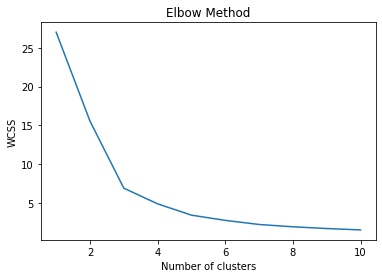

In [11]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(trains_set)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


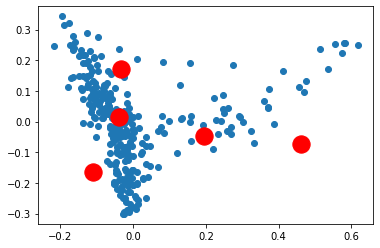

In [12]:

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(trains_set)
pred_y = kmeans.predict(tests_set)

plt.scatter(tests_set[:,0], tests_set[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()


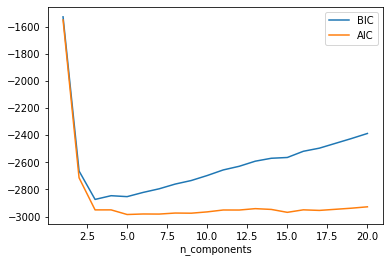

array([[5.57414916e-035, 4.86904600e-041, 5.09816693e-004,
        9.99490183e-001, 7.40055349e-025],
       [9.54860486e-001, 7.23695373e-019, 9.86068004e-028,
        2.33803866e-002, 2.17591278e-002],
       [4.66520600e-162, 8.34837304e-162, 6.01941338e-013,
        1.00000000e+000, 2.75394371e-144],
       ...,
       [7.17256905e-004, 3.97567018e-002, 2.45816829e-014,
        1.03356831e-001, 8.56169210e-001],
       [2.54352220e-021, 6.12278388e-025, 7.99354787e-006,
        9.99992006e-001, 1.91406098e-014],
       [2.29216086e-144, 2.88463750e-144, 9.29891715e-014,
        1.00000000e+000, 1.92299423e-129]])

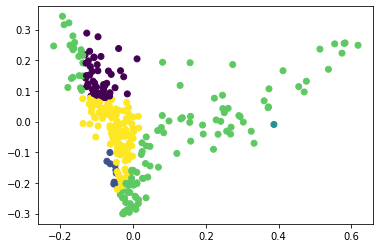

In [13]:
from sklearn.mixture import GaussianMixture #EM
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(trains_set) for n in n_components]
plt.plot(n_components, [m.bic(trains_set) for m in models], label='BIC')
plt.plot(n_components, [m.aic(trains_set) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()
gmm = GaussianMixture(n_components=5)
gmm.fit(trains_set)

labels=gmm.predict(tests_set)
plt.scatter(tests_set[:,0],tests_set[:,1],c=labels,cmap='viridis')
gmm.predict_proba(tests_set)

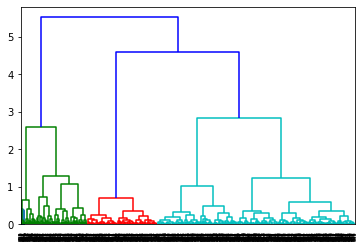

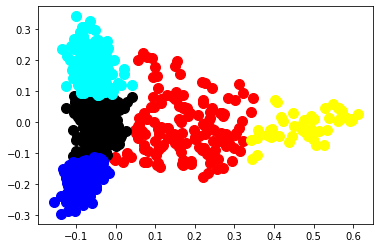

In [14]:
# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
plt.scatter(corpus_set[:,0], corpus_set[:,1], cmap='viridis')

dendrogram = sch.dendrogram(sch.linkage(corpus_set, method='ward'))
plt.show()
# create clusters
hc = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(corpus_set)

plt.scatter(corpus_set[y_hc ==0,0], corpus_set[y_hc == 0,1], s=100, c='red')
plt.scatter(corpus_set[y_hc==1,0], corpus_set[y_hc == 1,1], s=100, c='black')
plt.scatter(corpus_set[y_hc ==2,0], corpus_set[y_hc == 2,1], s=100, c='blue')
plt.scatter(corpus_set[y_hc ==3,0], corpus_set[y_hc == 3,1], s=100, c='cyan')
plt.scatter(corpus_set[y_hc ==4,0], corpus_set[y_hc == 4,1], s=100, c='yellow')

In [15]:
from gensim.models import LdaModel

# Set training parameters.
num_topics =10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

from gensim.corpora import Dictionary

x=[doc for doc in df['dict_clean']]
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(x)):
  x[idx]=tokenizer.tokenize(x[idx])

from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(x, min_count=20)
for idx in range(len(x)):
    for token in bigram[x[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            x[idx].append(token)

from gensim.corpora import Dictionary
dictionary=Dictionary(x)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in x]

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Average topic coherence: -1.1813.


In [16]:
!pip install pyLDAvis==3.2.2
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary=dictionary)
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 12.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135617 sha256=3039a934c81eb05e979cd0653e3c2887a6fde2158344044e3de8271df33cd648
  Stored in directory: /root/.cache/pip/wheels/f8/b1/9b/560ac1931796b7303f7b517b949d2d31a4fbc512aad3b9f284
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.034472  0.130964       1        1  17.891116
8      0.110753 -0.057684       2        1  15.208425
3     -0.079280 -0.082789       3        1  14.714447
7     -0.031366  0.032709       4        1  13.418656
4     -0.105266 -0.113687       5        1  10.080622
0     -0.041616 -0.041484       6        1   8.313541
2     -0.025010  0.075314       7        1   7.513949
5     -0.025831  0.056189       8        1   4.748085
6      0.259737 -0.017329       9        1   4.615238
1     -0.027650  0.017797      10        1   3.495921, topic_info=        Term        Freq       Total Category  logprob  loglift
189      how  537.000000  537.000000  Default  30.0000  30.0000
198      sir  377.000000  377.000000  Default  29.0000  29.0000
235     king  684.000000  684.000000  Default  28.0000  28.0000
3    chapter  307.000000  307.000000  Default  27.0000  27.0000
177     thou  313.000000  313.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
322     many   12.092238  165.967554  Topic10  -5.2200   0.7343
69      then   13.454052  536.476522  Topic10  -5.1132  -0.3322
266    would   13.313096  479.220957  Topic10  -5.1238  -0.2298
54      have   13.518647  612.608369  Topic10  -5.1084  -0.4601
20       not   13.219589  750.922018  Topic10  -5.1308  -0.6860

[620 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
41        1  0.374941  about
41        2  0.046868  about
41        3  0.114565  about
41        4  0.078113  about
41        5  0.057283  about
...     ...       ...    ...
40        6  0.004006   your
40        7  0.004006   your
40        8  0.004006   your
40        9  0.004006   your
40       10  0.008012   your

[2583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 4, 8, 5, 1, 3, 6, 7, 2])

In [17]:
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value

print(coherence)

topics =[
    ['king', 'him', 'horse', 'on'],
    ['great', 'then', 'sir', 'there']
         ]# randomly selected topics from LDAmodel top topics
cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence() 

print(coherence)

-1.181312984403438
-1.1852565191967894


In [18]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(labels, y_hc[int(len(y_hc)*0.7):len(y_hc)])#Kappa value for EM


-0.09834108922177376

In [19]:
cohen_kappa_score(pred_y, y_hc[int(len(y_hc)*0.7):len(y_hc)])#Kappa value for KMeans

0.22507877689571698

In [21]:
from sklearn.metrics import silhouette_score
silhouette_score (tests_set, pred_y, metric='euclidean') #silhouette for KMeans

0.4460267368760074

In [22]:
silhouette_score (tests_set, labels, metric='euclidean') #silhouette for EM

-0.08598277666215214